In [1]:
%load_ext pycodestyle_magic
%flake8_on
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from astropy.io import fits
from sklearn.decomposition import PCA
import glob2

In [4]:
def load_xmmspectra_raw(foldername, background=False):
    """Load XMM spectra with background."""
    pn_src_num, pn_specs, pn_bgs = load_det_spectra(foldername, 'PN',
                                                    background)
    mos_src_num, mos_specs, mos_bgs = load_det_spectra(foldername, 'MOS',
                                                       background)
    return ([pn_src_num, mos_src_num], [pn_specs, mos_specs],
            [pn_bgs, mos_bgs])


def load_det_spectra(foldername, det, background=False):
    """Load XMM spectra corresponding to given detector."""
    if det == 'PN':
        n_channels = 4096
    else:
        n_channels = 2400
    if foldername[-1] != '/':
        foldername = foldername + '/'
    spec_files = glob2.glob(foldername + '*_' + det + '_combined_src_grp1*.ds')
    spec_arr = np.zeros((len(spec_files), n_channels), dtype=np.float64)
    srcnum_arr = np.zeros(len(spec_files), dtype=int)
    if background:
        bgspec_arr = np.zeros((len(spec_files), n_channels), dtype=np.float64)
    else:
        bgspec_arr = None

    for i, spec_file in enumerate(spec_files):
        spec = fits.open(spec_file)
        spec_arr[i] = spec[1].data['counts']
        srcnum_arr[i] = int(spec_file.split('/')[-1].split('_')[0])
        if background:
            bg_file = (foldername + str(srcnum_arr[i]) + '_' + det +
                       '_combined_bkg_grp.ds')
            bg_spec = fits.open(bg_file)
            bgspec_arr[i] = bg_spec[1].data['counts']*(
                spec[1].header['backscal'] / bg_spec[1].header['backscal'])

    return srcnum_arr, spec_arr, bgspec_arr


def get_enbins_centres(resp_file):
    """Get Energy bins and centres."""
    response = fits.open(resp_file)
    energy_bins = response[2].data
    emin = energy_bins['E_MIN']
    emax = energy_bins['E_MAX']
    e_centres = 0.5*(emin + emax)
    return emin, emax, e_centres

In [5]:
xmm_highspecs = glob2.glob('../data/Galactic_highNH_combinedXMM/*_PN_combined_src_grp1*.ds')

In [6]:
xmm_highspecs[0].split('/')[-1].split('_')

['201129702010027', 'PN', 'combined', 'src', 'grp1', '257cts.ds']

In [7]:
spec1 = fits.open(xmm_highspecs[0])
spec1[1].header['BACKSCAL']

105913.0

In [51]:
bg1 = fits.open('../data/Galactic_highNH_combinedXMM/' + xmm_highspecs[0].split('/')[-1].split('_')[0]
                   + '_' + 'PN' + '_combined_bkg_grp.ds')

1:80: E501 line too long (102 > 79 characters)
2:20: E127 continuation line over-indented for visual indent


In [56]:
bg1[1].header['BACKSCAL']

9168381.29278257

In [ ]:
plt.plot(spec1)
plt.plot(bg1)

In [8]:
([pn_src_num, mos_src_num], [pn_specs, mos_specs],
 [pn_bgs, mos_bgs]) = load_xmmspectra_raw(
    '../data/Galactic_highNH_combinedXMM/', background=True)

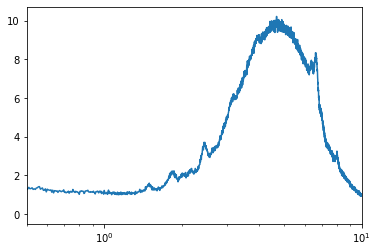

In [9]:
plt.plot(pn_ecentres, np.mean(pn_specs, axis=0))
plt.xlim(0.5, 10)
plt.xscale('log')

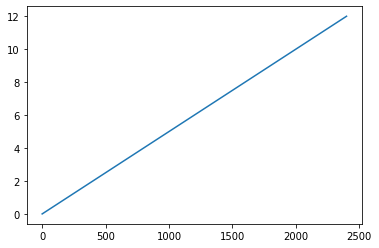

In [40]:
plt.plot(mos_ecentres)

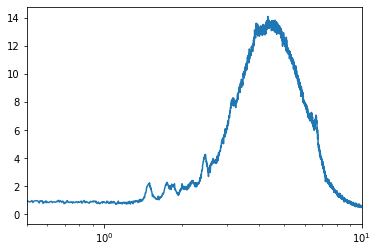

In [61]:
plt.plot(mos_ecentres, np.mean(mos_specs, axis=0))
plt.xlim(0.5, 10)
plt.xscale('log')

In [9]:
pn_emin, pn_emax, pn_ecentres = get_enbins_centres(
    '../XMM_responses/PN/epn_bu23_dY9.rmf.gz')
mos_emin, mos_emax, mos_ecentres = get_enbins_centres(
    '../XMM_responses/MOS_5eV/m1_e10_im_p0_c.rmf')

In [33]:
ecentres[61]

0.32754153

In [12]:
pn_netspecs = pn_specs - pn_bgs
pn_netcounts = np.sum(pn_netspecs, axis=1)
pn_norm_netspec = (pn_netspecs.transpose()/pn_netcounts).transpose()

In [26]:
pn_50ev_bins, pn_netspecs_50ev_binned = bin_spectra(
    pn_netspecs, pn_emin, [0.5, 10.0], 0.05)[:2]
pn_50ev_bincenters = 0.5*(pn_50ev_bins[:-1]+pn_50ev_bins[1:])

[0.5, 10.0]


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [27]:
print(pn_netspecs_50ev_binned.shape, pn_50ev_bins.shape)

(516, 189) (190,)


(0.5, 10.0)

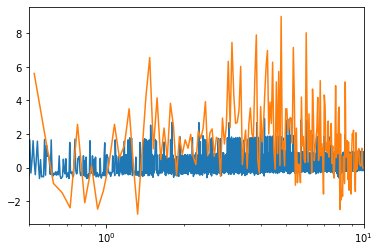

In [34]:
plt.plot(pn_ecentres, pn_netspecs[5])
plt.plot(pn_50ev_bincenters, pn_netspecs_50ev_binned[5])
plt.xscale('log')
plt.xlim(0.5, 10.0)

In [38]:
pn_refined_netcounts = np.sum(pn_netspecs_50ev_binned, axis=1)
pn_norm_50ev_netspecs = (pn_netspecs_50ev_binned.transpose()/(pn_refined_netcounts)).transpose()

In [140]:
pn_refined_netcounts[:10]

array([2.64308639e+02, 1.26836479e+02, 8.18146276e+01, 2.38169251e+02,
       9.43509666e+01, 3.24475636e+02, 1.49759102e+03, 7.41451771e+05,
       5.14974900e+02, 1.56735479e+03])

In [219]:
# Consider only sources with net counts > 0
if np.any(pn_refined_netcounts <= 100):
    pn_netspecs_50ev_binned = pn_netspecs_50ev_binned[pn_refined_netcounts > 100]
    pn_refined_netcounts = pn_refined_netcounts[pn_refined_netcounts > 100]
    pn_norm_50ev_netspecs = (pn_netspecs_50ev_binned.transpose() /
                             pn_refined_netcounts).transpose()

3:80: E501 line too long (81 > 79 characters)


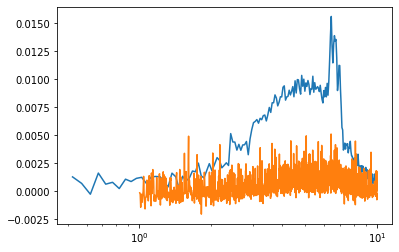

In [220]:
plt.plot(pn_50ev_bincenters, np.mean(pn_norm_50ev_netspecs, axis=0))
plt.plot(pn_ecen_refined, np.mean(pn_norm_netspec_refined, axis=0))
plt.xscale('log')

In [37]:
print(pn_netcounts)

[ 2.68447778e+02  1.09337445e+02  8.66354242e+01  2.48051406e+02
  1.17619995e+02  3.35514275e+02  1.52771627e+03  7.62352579e+05
  5.20573942e+02  1.60724549e+03  5.80707496e+02  4.43750736e+03
  5.46828710e+02  1.14179813e+02  5.25450020e+01  2.69064796e+03
  2.37686783e+02  2.80885402e+02  1.54791072e+03  2.67240888e+02
  3.62422165e+02  5.94752606e+01 -3.41484164e+01  3.04877696e+01
  2.56142463e+02  4.79937647e+02  2.67159664e+01  7.95987697e+01
  2.41536229e+02  2.19931336e+02  7.34467744e+02  6.46628694e+01
  1.80503331e+02  4.52845863e+02  2.14366625e+02  5.31389265e+02
  4.30895423e+05  6.31096949e+04  5.57801218e+03  8.86453333e+02
  1.62791421e+02  5.61911853e+02  1.25966911e+03  1.68938592e+03
  8.43058976e+02  2.68134411e+02  3.39870425e+02  2.50715286e+03
  6.87078762e+02  6.11237238e+01  3.14393150e+02 -2.10750874e+02
  8.51766933e+03  2.44735904e+03  2.52273687e+02 -3.34929071e+01
  3.84043785e+02  1.26266925e+02  2.37634322e+01  1.05645885e+02
  1.90877602e+02  2.85654

(0.5, 10.0)

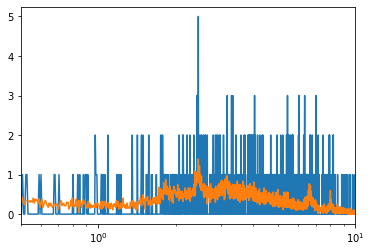

In [73]:
plt.plot(pn_ecentres, pn_specs[22])
plt.plot(pn_ecentres, pn_bgs[22])
plt.xscale('log')
plt.xlim(0.5, 10.0)

In [32]:
pn_netcounts[22]

-34.148416396822384

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


(array([  1.,   9., 128., 219.,  93.,  35.,  14.,   3.,   1.,   2.]),
 array([0.06815636, 0.69336138, 1.3185664 , 1.94377141, 2.56897643,
        3.19418145, 3.81938646, 4.44459148, 5.0697965 , 5.69500151,
        6.32020653]),
 <BarContainer object of 10 artists>)

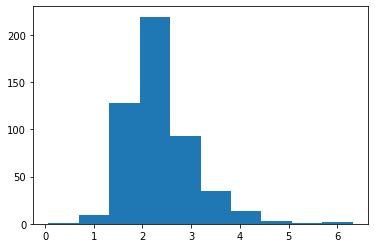

In [11]:
plt.hist(np.log10(pn_netcounts))

(0.5, 10.0)

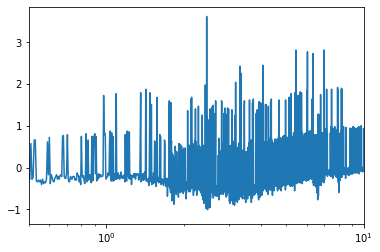

In [75]:
plt.plot(pn_ecentres, pn_netspecs[22])
plt.xscale('log')
plt.xlim(0.5, 10.0)

In [78]:
len(pn_netcounts[pn_netcounts>50])

449

1:30: E225 missing whitespace around operator


In [57]:
pn_norm_netspec_refined = pn_norm_netspec[:, 196:2000]

(1.0, 10.0)

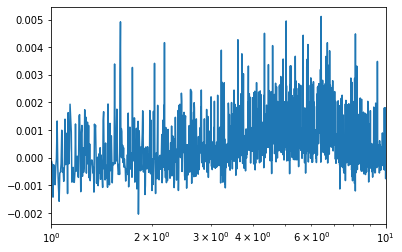

In [58]:
# Considering only sources with net counts more than 0
pn_norm_netspec = pn_norm_netspec[pn_netcounts > 0]
plt.plot(pn_ecen_refined, np.mean(pn_norm_netspec_refined, axis=0))
plt.xscale('log')
plt.xlim(1.0, 10.0)

In [94]:
np.where(pn_ecentres < 10.0)[0][-1]

1999

In [54]:
pn_ecen_refined = pn_ecentres[196:2000]

In [60]:
class PCASpec(PCA):
    """PCA decomposition of the spectra.

    Highest variance seems to come from the net count, when spectra is
    not normalized
    """
    def __init__(self, n_components, copy=True, whiten=False,
                 svd_solver='auto', tol=0.0, iterated_power='auto',
                 random_state=None):
        super().__init__(
            n_components, copy=copy, whiten=whiten, svd_solver=svd_solver,
            tol=tol, iterated_power=iterated_power, random_state=random_state)

    def spec_transform(self, src_spec, scaled_bgspec=None):
        """Transform spectra to lower dim space."""
        if scaled_bgspec is None:
            scaled_bgspec = np.zeros_like(src_spec)
        return self.transform(src_spec - scaled_bgspec)

    def spec_inv_transform(self, reduced_spec, scaled_bgspec=None):
        """Inverse transform the reduced spec."""
        if scaled_bgspec is None:
            return self.inverse_transform(reduced_spec)
        else:
            return self.inverse_transform(reduced_spec) + scaled_bgspec

    def call(self, src_spec, scaled_bgspec=None):
        """Decompose the spectra using PCA and then inverse transform."""
        if scaled_bgspec is None:
            scaled_bgspec = np.zeros_like(src_spec)
        return (
            self.inverse_transform(self.transform(src_spec - scaled_bgspec)) +
            scaled_bgspec)

In [147]:
pca_xmm = PCASpec(n_components=10)

In [148]:
pca_xmm.fit(pn_norm_50ev_netspecs)

PCASpec(n_components=10)

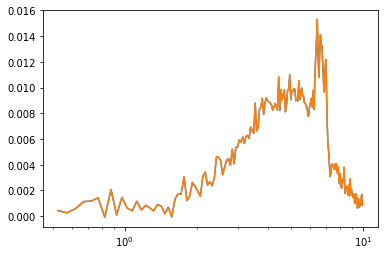

In [149]:
plt.plot(pn_50ev_bincenters, np.mean(pca_xmm.inverse_transform(
    pca_xmm.transform(pn_norm_50ev_netspecs)), axis=0))
plt.plot(pn_50ev_bincenters, np.mean(pn_norm_50ev_netspecs, axis=0))
plt.xscale('log')

In [71]:
from scipy import signal

In [150]:
len(pn_50ev_bincenters)

189

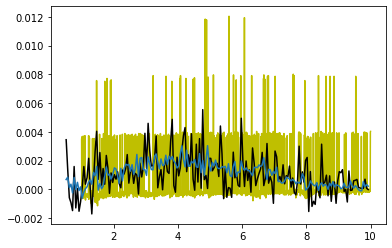

2:1: E265 block comment should start with '# '
2:80: E501 line too long (85 > 79 characters)


In [222]:
plt.plot(pn_ecen_refined, pn_norm_netspec_refined[3], color='y')
#plt.plot(pn_ecen_refined, signal.medfilt(pn_norm_netspec_refined[5], kernel_size=9))
plt.plot(pn_50ev_bincenters, pn_norm_50ev_netspecs[3]/5, color='k')
plt.plot(pn_50ev_bincenters, pca_xmm.inverse_transform(
    pca_xmm.transform(pn_norm_50ev_netspecs[3].reshape(1, 189))).transpose()/5)

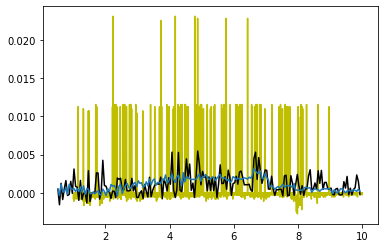

2:1: E265 block comment should start with '# '
2:80: E501 line too long (85 > 79 characters)


In [223]:
plt.plot(pn_ecen_refined, pn_norm_netspec_refined[2], color='y')
#plt.plot(pn_ecen_refined, signal.medfilt(pn_norm_netspec_refined[3], kernel_size=9))
plt.plot(pn_50ev_bincenters, pn_norm_50ev_netspecs[2]/5, color='k')
plt.plot(pn_50ev_bincenters, pca_xmm.inverse_transform(
    pca_xmm.transform(pn_norm_50ev_netspecs[2].reshape(1, 189))).transpose()/5)

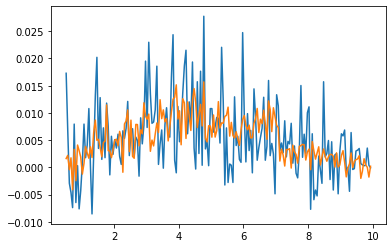

In [146]:
plt.plot(pn_50ev_bincenters, pn_norm_50ev_netspecs[5])
plt.plot(pn_50ev_bincenters, pca_xmm.inverse_transform(
    pca_xmm.transform(pn_norm_50ev_netspecs[5].reshape(1, 189))).transpose())

(6.0, 7.0)

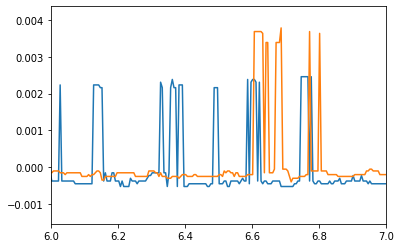

1:80: E501 line too long (84 > 79 characters)
2:1: E265 block comment should start with '# '
4:80: E501 line too long (84 > 79 characters)
5:1: E265 block comment should start with '# '


In [83]:
plt.plot(pn_ecen_refined, signal.medfilt(pn_norm_netspec_refined[5], kernel_size=9))
#plt.plot(pn_ecen_refined, signal.medfilt(pca_xmm.inverse_transform(
#    pca_xmm.transform(pn_norm_netspec_refined))[5], kernel_size=5))
plt.plot(pn_ecen_refined, signal.medfilt(pn_norm_netspec_refined[3], kernel_size=9))
#plt.plot(pn_ecen_refined, signal.medfilt(pca_xmm.inverse_transform(
#    pca_xmm.transform(pn_norm_netspec_refined))[3], kernel_size=5))
plt.xlim(6, 7)

In [89]:
pn_netcounts[3]

248.05140559485687

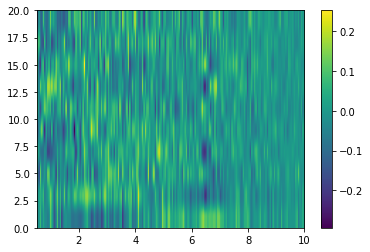

In [224]:
plt.imshow(pca_xmm.components_, aspect='auto', origin='lower',
           extent=[0.5, 10.0, 0.0, 20.0])
plt.colorbar()

(array([504.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.06881165,  1.53079219,  3.13039603,  4.72999987,  6.32960371,
         7.92920755,  9.5288114 , 11.12841524, 12.72801908, 14.32762292,
        15.92722676]),
 <BarContainer object of 10 artists>)

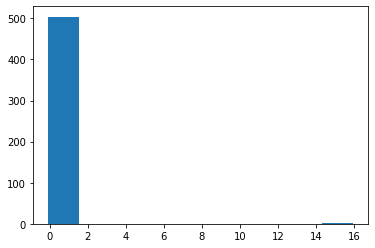

In [132]:
plt.hist(pca_xmm.transform(pn_norm_netspec_refined))

In [138]:
pn_src_num

array([200305401010008, 200305401010015, 200305401010016, 200305401010017,
       200305401010049, 200305401015015, 200305402010002, 201113501010010,
       201113501010017, 201113501010035, 201113501010066, 201113501010069,
       201113501010072, 201113501010077, 201113501010084, 201113501010092,
       201113501010093, 201113501010101, 201113501010111, 201113501010117,
       201113501010122, 201113501010131, 201113501010144, 201113501010148,
       201113501010151, 201113501010154, 201113501010156, 201113501010159,
       201113501010161, 201113501010162, 201113501010169, 201113501010173,
       201113501010175, 201113501015091, 201113501015104, 201113501015161,
       201113503010004, 201113503010008, 201129701010002, 201129701010011,
       201129701010012, 201129701010015, 201129701010016, 201129701010017,
       201129701010027, 201129701010028, 201129701010030, 201129701010035,
       201129701010041, 201129701010044, 201129701010051, 201129701010056,
       201129702010002, 2

In [10]:
def bin_spectra(spectra, e_channels, cutoff_en, opt_bin_width):
    """Bin the input spectra with the given bin_width.

    Note that this doesn't ensure min counts in each bin, so that all the
    input spectra have the same energy bins for the classification.
    Input:
    spectra - Input spectra. Can be 1D or 2D array.
    e_channel_min - Min energy bounds of the channels
    e_channel_max - Max energy bounds of the channels
    cutoff_en - Cut off energies for the output spectra. Shouble be an list
        with 2 values
    opt_bin_width - Optimum bin width. The function tries to make the actual
        size to be as close to opt_bin_width as possible. Exact case isn't
        always possible given that the spectra is also binned.
    """
    print(cutoff_en)
    # Perform sanity checks
    if cutoff_en[0] > cutoff_en[1]:
        raise ValueError("Min cut off energy greater than max cutoff energy")
    if cutoff_en[0] > e_channels[-1]:
        raise ValueError('Min cut off energy greater than max energy')
    if cutoff_en[1] < e_channels[0]:
        raise ValueError('Max cut off energy smaller than min energy')
    if ((isinstance(opt_bin_width, list) or
         isinstance(opt_bin_width, np.ndarray)) and (
             np.sum(opt_bin_width) < (cutoff_en[1] - cutoff_en[0]))):
        raise ValueError('Sum of bin widths must be greater than the' +
                         'energy interval needed.')

    cutoff_min_arg = np.searchsorted(e_channels, cutoff_en[0])
    cutoff_max_arg = np.searchsorted(e_channels, cutoff_en[1])
    if e_channels[cutoff_max_arg] > cutoff_en[1]:
        cutoff_max_arg -= 1

    # Merging e_channel_min and e_channel_max into single array of energy bins
    e_channel_bins = e_channels[cutoff_min_arg:cutoff_max_arg+1]

    # Get energy bins according to input bin_widths
    if isinstance(opt_bin_width, (float, np.float)):
        num_bins = int((e_channel_bins[-1] - e_channel_bins[0])/opt_bin_width)
        opt_bin_en = (e_channel_bins[0] +
                      np.arange(0, num_bins+1)*opt_bin_width)
    elif isinstance(opt_bin_width, (list, np.ndarray)):
        opt_bin_en = e_channel_bins[0] + np.cumsum(opt_bin_width)
        opt_bin_en = np.append(e_channel_bins[0], opt_bin_en.copy())
        opt_bin_en = opt_bin_en[np.where(opt_bin_en <= e_channel_bins[-1])]

    # Adjust opt_bin to match with the boundaries of e_channel_bins
    opt_bin_args = np.searchsorted(e_channel_bins, opt_bin_en)
    for i, args in enumerate(opt_bin_args):
        if opt_bin_en[i] != e_channel_bins[args]:
            diff_lower = opt_bin_en[i] - e_channel_bins[args-1]
            diff_up = e_channel_bins[args] - e_channel_bins[i]
            if diff_lower < 0 or diff_up < 0:
                raise ValueError('Something is wrong. Check the differences')
            if diff_lower < diff_up:
                opt_bin_args[i] = args - 1

    if len(spectra.shape) == 1:
        binned_spectra = np.zeros(len(opt_bin_args) - 1, dtype=np.float64)
    elif len(spectra.shape) == 2:
        binned_spectra = np.zeros((len(spectra), len(opt_bin_args) - 1),
                                  dtype=np.float64)
    else:
        raise ValueError("Shape of spectra can only be 1D or 2D")
    for i, args in enumerate(opt_bin_args[:-1]):
        if len(spectra.shape) == 1:
            binned_spectra[i] = np.sum(
                spectra[cutoff_min_arg+args:cutoff_min_arg+opt_bin_args[i+1]])
        else:
            binned_spectra[:, i] = np.sum(
                spectra[:,
                        cutoff_min_arg+args:cutoff_min_arg+opt_bin_args[i+1]],
                axis=1)

    return (e_channel_bins[opt_bin_args], binned_spectra, opt_bin_args[0],
            opt_bin_args[-1])

In [11]:
def spec_loss(src_spec, model_spec, bg_spec=None, weights=None):
    """Poisson related loss between model spectra and source spectra.
    
    If inputs are normalized spectra, use the net_counts/energy_bin as weights.
    """
    sr_spec = src_spec.copy()
    if bg_spec is None:
        bg_spec = np.zeros_like(model_spec)  # Bg is zero if no background
    if weights is None:
        weights = np.ones(len(model_spec), dtype=float)  # Equal weights
    recon_src_spec = model_spec + bg_spec
    if np.any(recon_src_spec <= 0.0):
        print("Some values of model spec are negative.")
        print("Converting them to 1.0E-16.")
        recon_src_spec[recon_src_spec <= 0.0] = 1.0E-16
    if np.any(src_spec == 0):
        print("Zero values in source spec are taken as 1.0E-16")
        sr_spec[src_spec <= 0.0] = 1.0E-16
    loss_arr = recon_src_spec - sr_spec - sr_spec*np.log(recon_src_spec /
                                                         sr_spec) # Loss arr
    loss_arr_weighted = np.multiply(
        loss_arr, weights.reshape(len(src_spec), 1)) # Weighted loss
    loss = 2*np.sum(loss_arr_weighted)/len(src_spec) # C-statistic
    return loss


def compare_pca(src_spec, bg_spec=None, num_comps=None, weights=None):
    """Compare PCA decomposition for different number of nodes."""
    if bg_spec is None:
        bg_spec = np.zeros_like(src_spec)
    if num_comps is None:
        num_comps = [2, 3, 4, 7, 10, 14, 21, 32, 47, 70, 103, 151]      # Number of components
    pca_list = []
    pca_transformed_specs = []
    loss_arr = np.zeros(len(num_comps), dtype=np.float64)
    aicc_arr = np.zeros_like(loss_arr)
    pca_recon_spec = np.zeros((len(num_comps), len(src_spec),
                               len(src_spec[0])), dtype=np.float64)
    for i, ncomp in enumerate(num_comps):
        pca_xmm = PCASpec(n_components=ncomp)
        pca_xmm.fit(src_spec - bg_spec)
        pca_recon_spec[i] = pca_xmm.call(src_spec, bg_spec)
        pca_transformed_specs.append(pca_xmm.spec_transform(src_spec, bg_spec))
        loss = spec_loss(src_spec, pca_recon_spec[i], weights=weights)
        loss_arr[i] = loss
        aicc_arr[i] = loss + 2*ncomp + 2*(ncomp**2 + ncomp)/(189 - ncomp - 1)
        pca_list.append(pca_xmm)
    return (num_comps, pca_list, loss_arr, aicc_arr, pca_transformed_specs,
            pca_recon_spec)

3:1: W293 blank line contains whitespace
20:66: E261 at least two spaces before inline comment
22:53: E261 at least two spaces before inline comment
23:53: E261 at least two spaces before inline comment
32:80: E501 line too long (94 > 79 characters)


In [225]:
(pca_numcomps, pca_list, pca_losses, pca_aiccs, pca_trans_specs,
 pca_recon_specs) = compare_pca(pn_norm_50ev_netspecs)

Some values of model spec are negative.
Converting them to 1.0E-16.
Zero values in source spec are taken as 1.0E-16
Some values of model spec are negative.
Converting them to 1.0E-16.
Zero values in source spec are taken as 1.0E-16
Some values of model spec are negative.
Converting them to 1.0E-16.
Zero values in source spec are taken as 1.0E-16
Some values of model spec are negative.
Converting them to 1.0E-16.
Zero values in source spec are taken as 1.0E-16
Some values of model spec are negative.
Converting them to 1.0E-16.
Zero values in source spec are taken as 1.0E-16
Some values of model spec are negative.
Converting them to 1.0E-16.
Zero values in source spec are taken as 1.0E-16
Some values of model spec are negative.
Converting them to 1.0E-16.
Zero values in source spec are taken as 1.0E-16
Some values of model spec are negative.
Converting them to 1.0E-16.
Zero values in source spec are taken as 1.0E-16
Some values of model spec are negative.
Converting them to 1.0E-16.
Zero

0
1
2
3
4
5
6
7


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


8
9
10
11


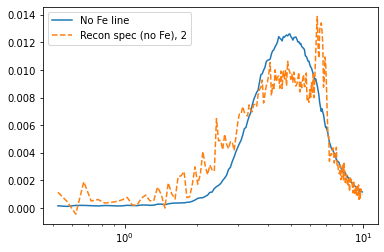

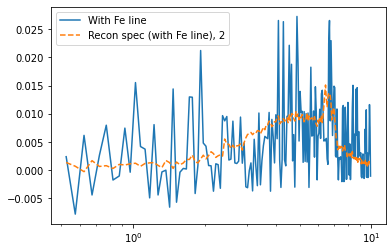

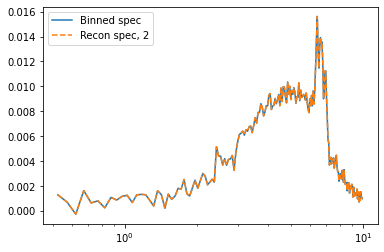

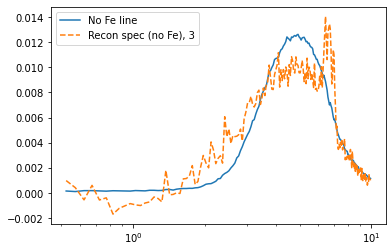

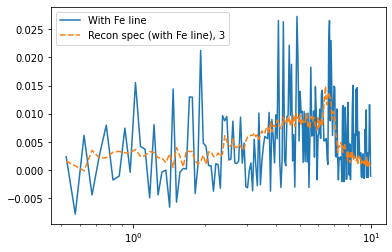

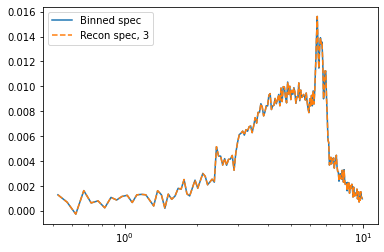

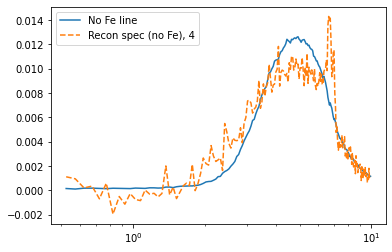

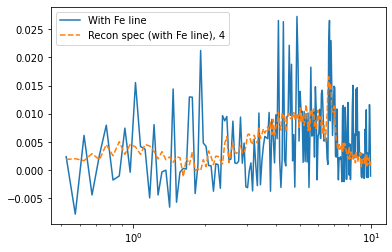

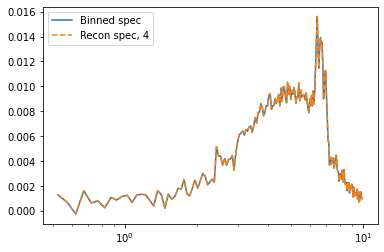

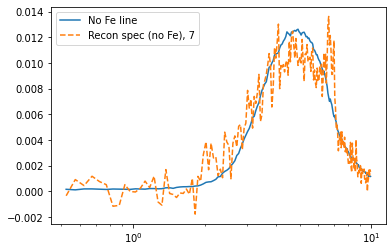

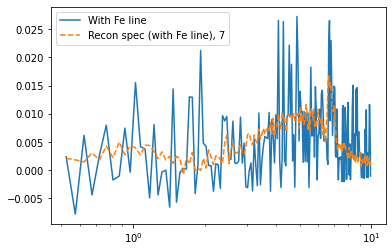

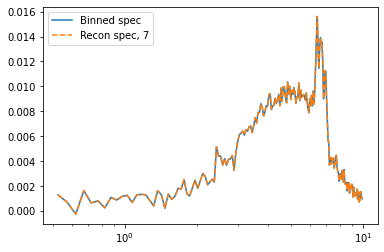

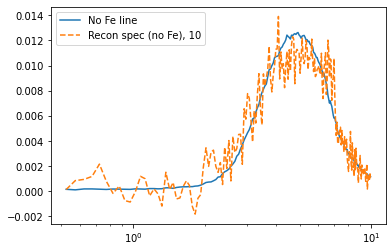

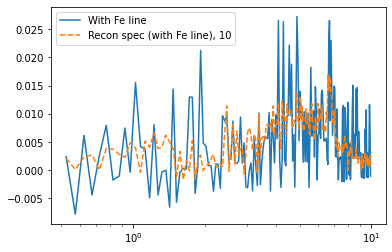

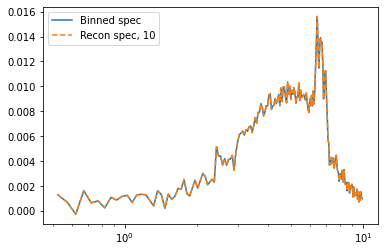

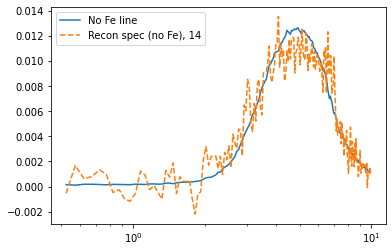

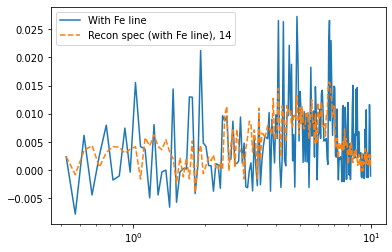

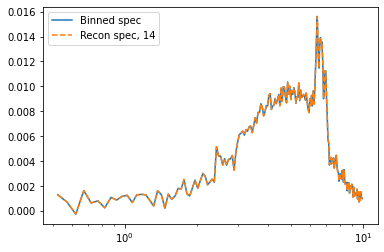

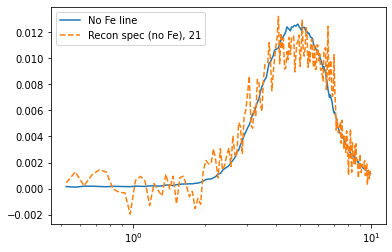

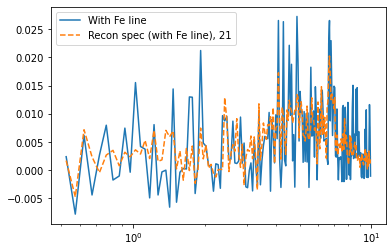

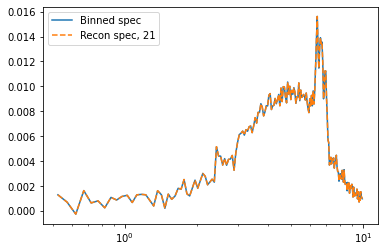

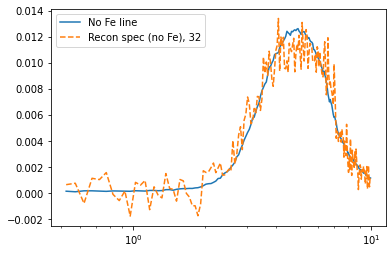

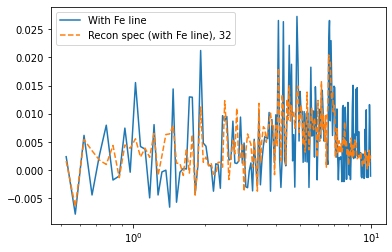

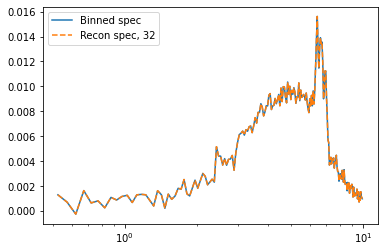

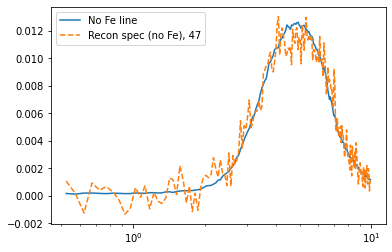

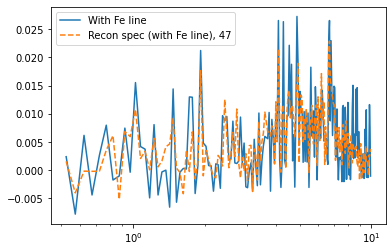

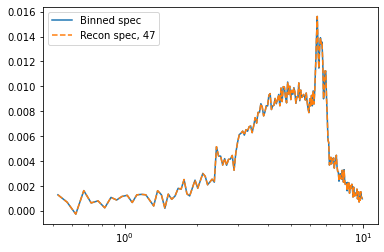

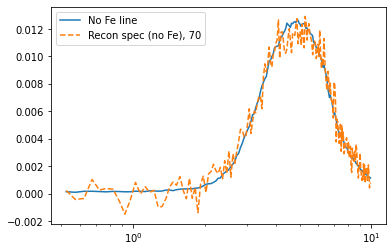

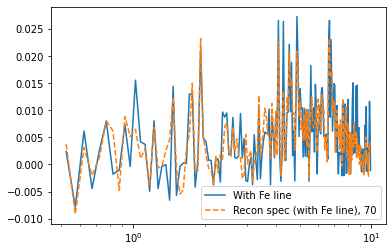

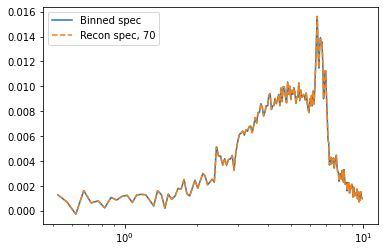

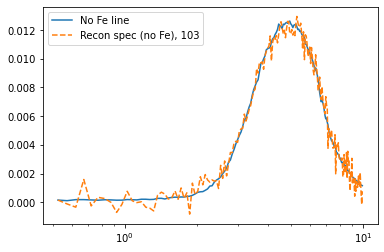

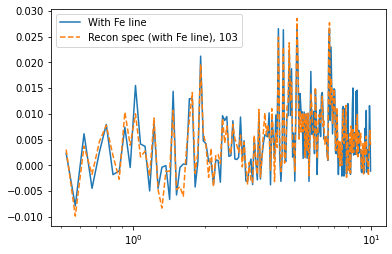

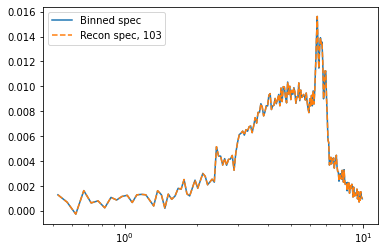

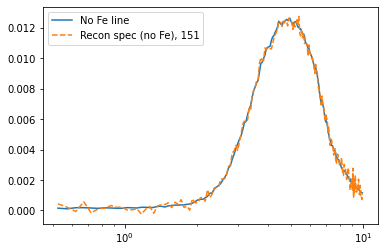

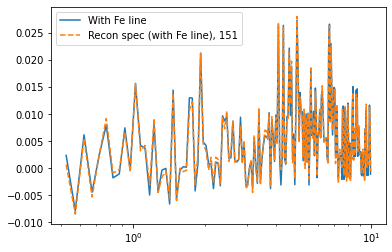

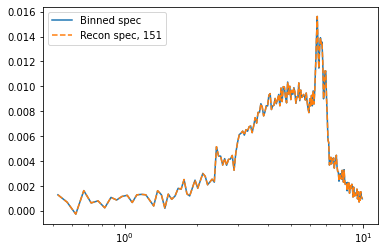

4:80: E501 line too long (108 > 79 characters)
8:80: E501 line too long (80 > 79 characters)
9:80: E501 line too long (115 > 79 characters)
13:80: E501 line too long (93 > 79 characters)
14:80: E501 line too long (114 > 79 characters)


In [228]:
for i, ncomps in enumerate(pca_numcomps):
    plt.figure()
    plt.plot(pn_50ev_bincenters, pn_norm_50ev_netspecs[5], label='No Fe line')
    plt.plot(pn_50ev_bincenters, pca_recon_specs[i][5], label='Recon spec (no Fe), ' + str(ncomps), ls='--')
    plt.xscale('log')
    plt.legend()
    plt.figure()
    plt.plot(pn_50ev_bincenters, pn_norm_50ev_netspecs[2], label='With Fe line')
    plt.plot(pn_50ev_bincenters, pca_recon_specs[i][2], label='Recon spec (with Fe line), ' + str(ncomps), ls='--')
    plt.xscale('log')
    plt.legend()
    plt.figure()
    plt.plot(pn_50ev_bincenters, np.mean(pn_norm_50ev_netspecs, axis=0), label='Binned spec')
    plt.plot(pn_50ev_bincenters, np.mean(pca_recon_specs[i], axis=0), label='Recon spec, ' + str(ncomps), ls='--')
    plt.xscale('log')
    plt.legend()
    print(i)

In [183]:
from sklearn.mixture import GaussianMixture

In [229]:
gmm_xmm = GaussianMixture(n_components=8)

In [230]:
gmm_xmm.fit(pca_trans_specs[8])

GaussianMixture(n_components=8)

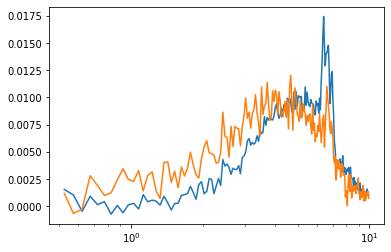

1:1: E265 block comment should start with '# '


In [234]:
#plt.plot(pn_50ev_bincenters, pca_list[2].inverse_transform(gmm_xmm.means_[0]))
plt.plot(pn_50ev_bincenters, pca_list[8].inverse_transform(gmm_xmm.means_[1]))
plt.plot(pn_50ev_bincenters, pca_list[8].inverse_transform(gmm_xmm.means_[4]))
plt.xscale('log')

In [ ]:
len(pca_)

In [235]:
for i in range(10):
    print(i, len(np.where(gmm_xmm.predict(pca_trans_specs[8]) == i)[0]))

0 3
1 237
2 1
3 1
4 83
5 1
6 3
7 1
8 0
9 0


In [236]:
np.where(gmm_xmm.predict(pca_trans_specs[8]) == 4)

(array([  1,  13,  16,  20,  21,  23,  46,  48,  63,  66,  67,  73,  74,
         75,  89,  96, 101, 119, 124, 131, 137, 138, 143, 150, 170, 174,
        191, 196, 207, 209, 210, 213, 216, 224, 226, 228, 233, 235, 236,
        239, 240, 241, 243, 244, 251, 253, 256, 257, 262, 263, 264, 266,
        269, 270, 273, 275, 276, 278, 279, 283, 285, 287, 290, 294, 295,
        296, 298, 299, 300, 303, 304, 308, 309, 315, 318, 319, 321, 323,
        324, 325, 326, 327, 329]),)

In [237]:
pn_refined_netcounts[np.where(gmm_xmm.predict(pca_trans_specs[8]) == 4)]

array([126.83647902, 251.71550661, 249.93493103, 249.91878514,
       189.31383272, 151.7968968 , 111.16667743, 257.95295618,
       179.88904651, 145.67270755, 194.97885865, 128.85966998,
       110.9078242 , 251.649614  , 180.56318793, 123.37337318,
       105.10297465, 112.47341132, 116.76208233, 143.68865506,
       134.5871864 , 126.81532417, 119.65758892, 191.63319702,
       214.05391269, 495.66798683, 504.22772556, 100.61914382,
       221.98043646, 101.76355897, 187.95140275, 268.59904589,
       337.44568618, 200.27622515, 165.88583092, 131.82761318,
       105.77342881, 175.09644501, 104.89236282, 214.7727905 ,
       393.43290201, 287.43098907, 334.37128293, 142.43644943,
       129.13416327, 139.57585464, 235.84335697, 134.2129373 ,
       163.00360161, 141.901471  , 153.54616803, 130.23421221,
       222.55948749, 119.32331625, 138.94580561, 184.27432491,
       115.57361236, 113.32584338, 230.45935241, 139.81366048,
       214.39548273, 103.01382076, 184.93428349, 118.14

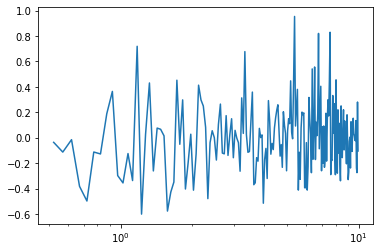

In [117]:
plt.plot(pn_50ev_bincenters, pn_norm_50ev_netspecs[358])
plt.xscale('log')

In [133]:
pn_ecentres[1999]

9.997499

In [120]:
pn_refined_netcounts[358]

7.497842591495104

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


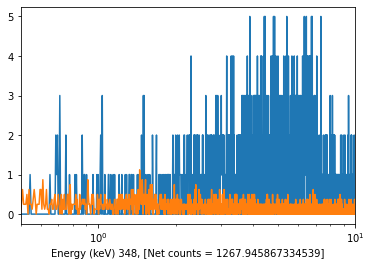

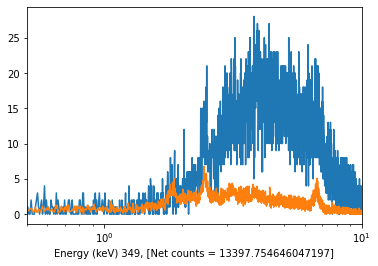

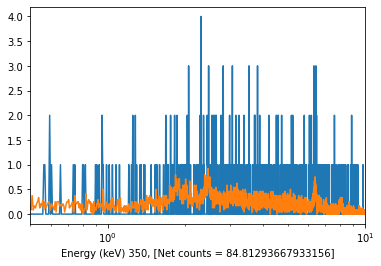

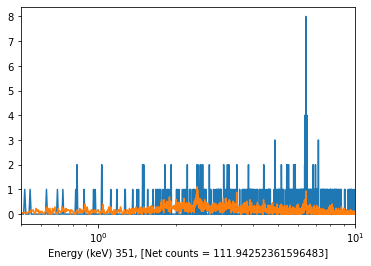

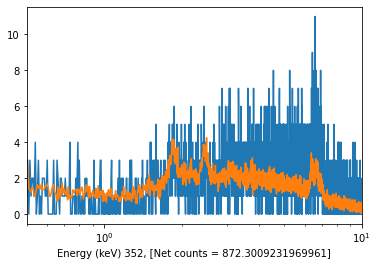

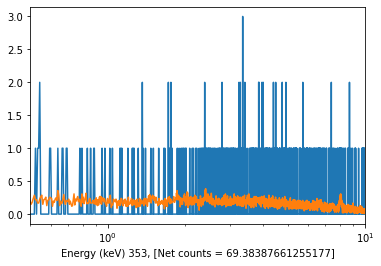

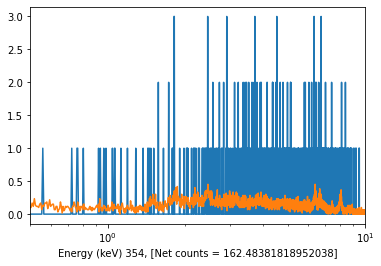

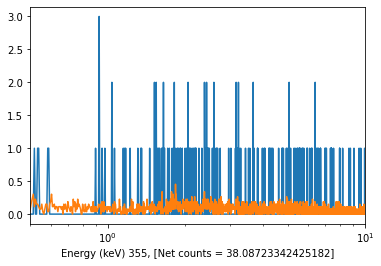

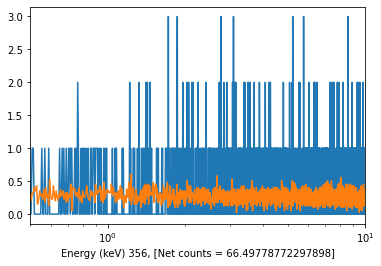

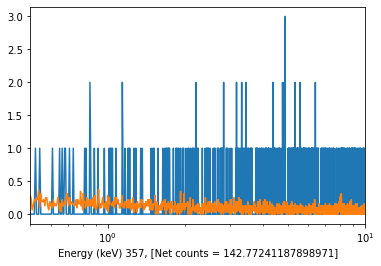

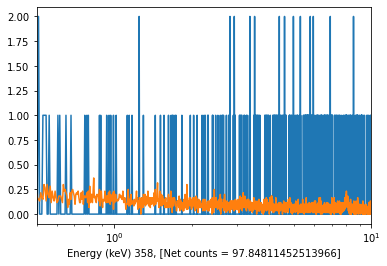

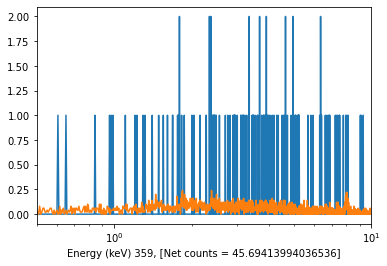

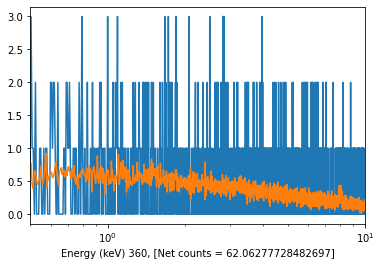

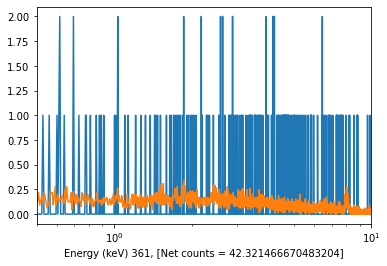

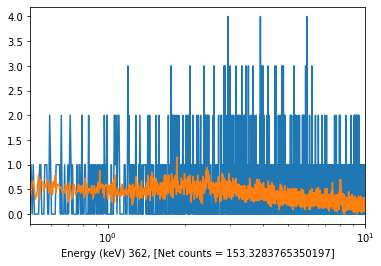

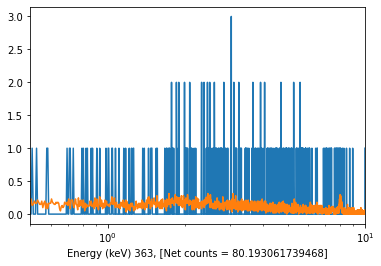

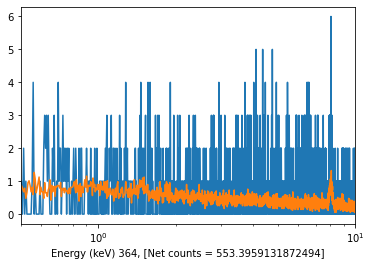

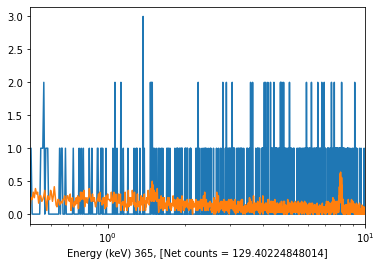

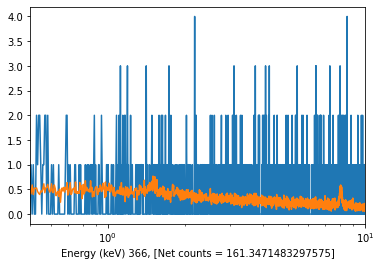

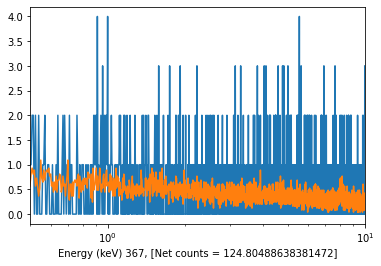

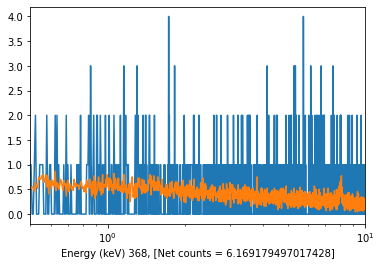

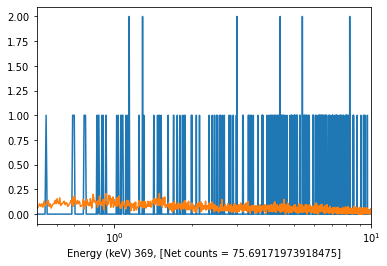

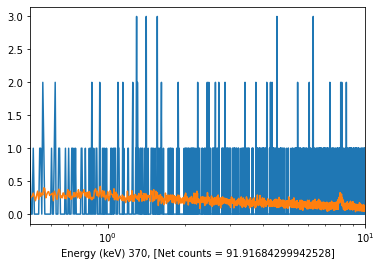

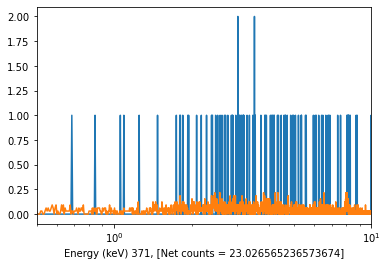

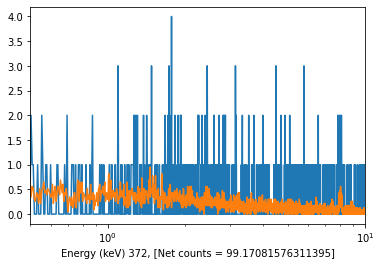

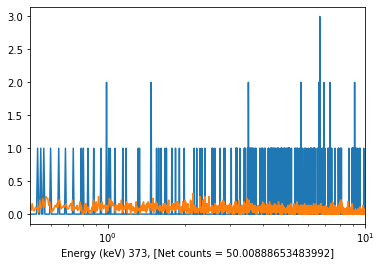

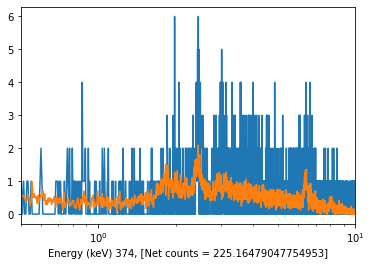

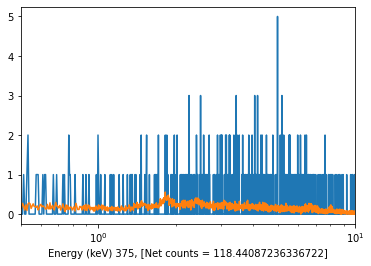

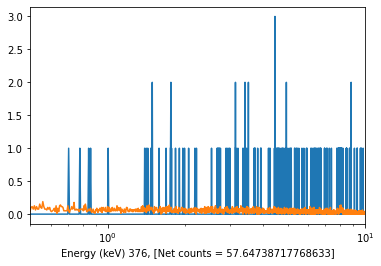

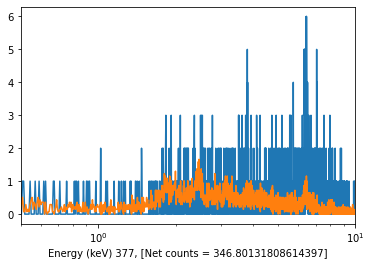

6:70: E225 missing whitespace around operator


In [138]:
for i in range(348, 378):
    plt.figure()
    plt.plot(pn_ecentres[92:1999], pn_specs[i, 92:1999])
    plt.plot(pn_ecentres[92:1999], pn_bgs[i, 92:1999])
    plt.xlabel('Energy (keV) ' + str(i) + ', [Net counts = ' +
               str(np.sum(pn_specs[i, 92:1999]-pn_bgs[i, 92:1999])) +']')
    plt.xlim(0.5, 10.0)
    plt.xscale('log')

In [266]:
np.where(pn_ecentres <= 6.2)[0][-1]

1239

In [245]:
np.where(pn_ecentres >= 6.9)[0][0]

1380

In [241]:
np.where(pn_ecentres < 5.5)[0][-1]

1099

In [242]:
np.where(pn_ecentres > 7.6)[0][0]

1520

In [268]:
iron_line_counts = np.sum(pn_netspecs[:, 1239:1380], axis=1)
iron_line_left = np.sum(pn_netspecs[:, 1099:1239], axis=1)
iron_line_right = np.sum(pn_netspecs[:, 1380:1520], axis=1)
iron_region_mean = (iron_line_left+iron_line_right)/2.0
iron_region_ratio = iron_line_counts/iron_region_mean

(-10.0, 10.0)

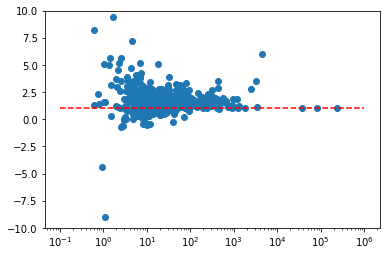

In [348]:
plt.scatter(iron_region_mean, iron_region_ratio)
plt.plot(np.logspace(-1, 6, 1000), np.ones(1000), ls='--', color='r')
plt.xscale('log')
plt.ylim(-10, 10)

In [330]:
np.where(np.logical_and(np.abs(iron_region_ratio) < 0.5,
                        iron_region_mean > 10))[0]

array([ 77, 116, 207, 214, 232, 311, 362, 419, 432, 438, 513])

In [331]:
pn_netcounts[np.where(np.logical_and(np.abs(iron_region_ratio) < 0.5,
                        iron_region_mean > 10))[0]]

array([170.18091974, 119.78224116, 938.00748814, 258.5727808 ,
       538.71842515, 145.7895062 , 199.74343867, 218.27200519,
        79.89660316, 142.89035749,  83.74387783])

2:25: E128 continuation line under-indented for visual indent


In [334]:
iron_region_ratio[77]

0.46989736824199757

In [297]:
 pn_netcounts[np.where(np.logical_and(
    iron_region_ratio < 2.0, np.logical_and(iron_region_mean > 1.0,
                                            iron_region_mean < 10000.0)))[0]]

array([ 2.68447778e+02,  8.66354242e+01,  2.48051406e+02,  3.35514275e+02,
        1.52771627e+03,  5.20573942e+02,  1.60724549e+03,  5.80707496e+02,
        4.43750736e+03,  1.14179813e+02,  5.25450020e+01,  2.69064796e+03,
        2.80885402e+02,  1.54791072e+03,  2.67240888e+02,  3.62422165e+02,
        5.94752606e+01, -3.41484164e+01,  3.04877696e+01,  2.56142463e+02,
        4.79937647e+02,  2.67159664e+01,  7.95987697e+01,  2.41536229e+02,
        2.19931336e+02,  7.34467744e+02,  6.46628694e+01,  1.80503331e+02,
        2.14366625e+02,  5.57801218e+03,  8.86453333e+02,  1.62791421e+02,
        5.61911853e+02,  1.25966911e+03,  1.68938592e+03,  8.43058976e+02,
        2.68134411e+02,  3.39870425e+02,  2.50715286e+03,  6.87078762e+02,
        6.11237238e+01,  3.14393150e+02, -2.10750874e+02,  8.51766933e+03,
        3.84043785e+02,  2.37634322e+01,  1.90877602e+02,  2.85654963e+02,
        4.41842537e+02,  2.84108207e+03,  6.67985985e+02,  4.51923499e+02,
        1.01493626e+04,  

1: E999 IndentationError: unexpected indent
1:2: E111 indentation is not a multiple of four
1:2: E113 unexpected indentation


(0.5, 10.0)
(0.5, 10.0)


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


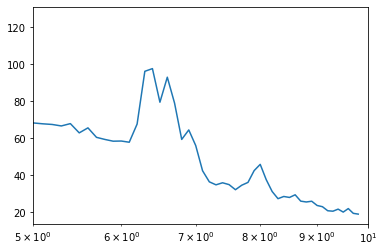

1:80: E501 line too long (130 > 79 characters)
4:1: E265 block comment should start with '# '


In [346]:
plt.plot(bin_spectra(pn_netspecs[207], pn_emin, (0.5, 10.0), 0.1)[0][:-1], bin_spectra(pn_bgs[232], pn_emin, (0.5, 10.0), 0.1)[1])
plt.xlim(5, 10.0)
plt.xscale('log')
#plt.yscale('log')

In [295]:
bin_spectra(pn_netspecs[39], pn_emin, (0.5, 10.0), 0.05)[1]

(0.5, 10.0)


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


array([-2.80886889,  4.60834186,  4.02555261,  0.58988165, -3.34877211,
        5.20334402, -0.57569685,  4.25247735, -2.34877211, -5.58194415,
        3.71257413,  3.84747951,  3.73699994,  5.03151822,  1.3382494 ,
        1.25844295,  2.68786661, -3.5021377 , -0.55751833, -0.37944523,
        1.29536338,  1.38738273,  3.94546447,  7.90257844,  6.88411823,
        0.03748382,  1.54671393, -1.31213339,  4.1723892 ,  0.94546447,
        9.87190532,  7.11104297, 10.55892683,  3.74296555,  3.26440856,
        4.81652469,  8.08036985,  5.89633114,  3.6631591 ,  3.92700426,
       -1.50866671,  6.1661419 , 11.96989028, 11.58335265,  5.09258276,
        2.21527523,  5.0005634 ,  3.57113974,  2.73671824, 10.70604512,
        8.73671824,  6.95143007,  9.98210319, -2.40443444,  3.62623868,
        4.53421932,  4.79806448,  9.73671824,  5.31950749,  9.81027739,
        6.44219997,  4.02498921,  7.38085373,  9.79806448, 11.17835481,
        0.62623868,  8.71825803,  4.19681502, 12.79181717,  7.27